# Identify the product category

**Problem Statement**  
The applications of Deep Neural Nets is on a roll. Whether it is healthcare, transportation, or retail, companies across all industries are excited about investing in building intelligent solutions. Meanwhile, let’s hope human intelligence remains uncontested.

In this challenge, you will help one of the largest retailers in Germany improve their inventory-management process in its Food and Groceries business. The company is looking for intelligent solutions that can reduce the amount of human effort in its warehouse and retail outlets.

A solution such as a powerful image classifier can help the company track shelf inventory, categorize products, record product volume etc.

You are required to predict the category of each product.

The link to hackerearth competition is here [hackerearth-identify-the-objects](https://www.hackerearth.com/problem/machine-learning/identify-the-objects/).

# Learning from Scratch using Keras

This notebook is created from this Keras blog https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In the blog the author @fchollet used only a few training examples but here we will use the entire dataset. In this notebook, we are going to build a classifier for 25 different product images. We only have around 150 images per class, which is nowhere near enough data to train a model from scratch.

We will go over the following options:

- training a small network from scratch (as a baseline) (this notebook)
- using the bottleneck features of a pre-trained network (next notebook)
- fine-tuning the top layers of a pre-trained network (next notebook)

We have already structured the images data in the following structure for the Keras ImageDataGenerator to work in our previous notebook.
```
data/
    train/
        beans/
            train_1a.png
            ...
            train_1b.png
        cake/
            train_2a.png
            ...
            train_2b.png
        candy/
        ...
        water
            train_25a.png
            ...
            train_25b.png
    valid/
        beans/
            train_1a.png
            ...
            train_1b.png
        cake/
            train_2a.png
            ...
            train_2b.png
        candy/
        ...
        water
            train_25a.png
            ...
            train_25b.png
    test/
        unknown/
            train_1a.png
            ...
            train_25b.png
```

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras import backend as K

from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
seed = 23
np.random.seed(seed)

In [5]:
KERAS_DATAGEN_TRAIN_IMG_PATH = 'data_gen/train/'
KERAS_DATAGEN_VALID_IMG_PATH = 'data_gen/valid/'
KERAS_DATAGEN_TEST_IMG_PATH = 'data_gen/test/'

In [6]:
# dimensions of our images.
IMG_WIDTH, IMG_HEIGHT = 256, 256

## 1. Data pre-processing and data augmentation

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class. This class allows us to:

- configure random transformations and normalization operations to be done on our image data during training
- instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs, `fit_generator`, `evaluate_generator` and `predict_generator`.

In [7]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

These are just a few of the options available (for more, see the [documentation](https://keras.io/preprocessing/image/). Let's quickly go over what we just wrote:

- `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- `rescale` is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- `shear_range` is for randomly applying shearing transformations
- `zoom_range` is for randomly zooming inside pictures
- `horizontal_flip` is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Now let's start generating some pictures using this tool, so we can get a feel for what our augmentation strategy is doing --we disable rescaling in this case to keep the images displayable:

In [8]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img('data_gen/train/beans/train_139d.png')  # this is a PIL image
img = img_to_array(img)  # this is a Numpy array with shape (256, 256, 3)
img = img.astype(np.float32)
img = np.expand_dims(img, axis =0) # this is a Numpy array with shape (1, 256, 256, 3)

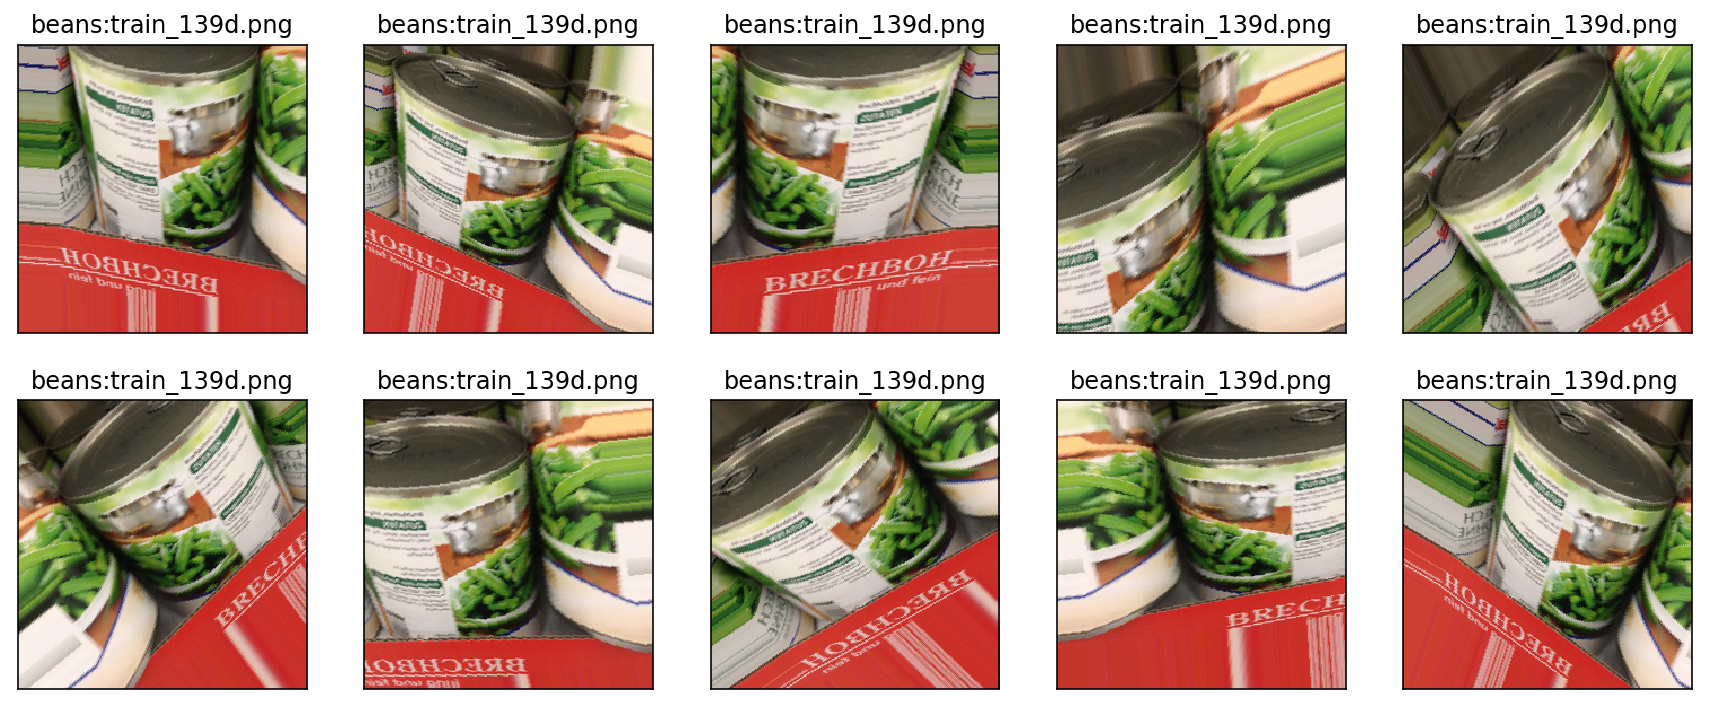

In [9]:
# the .flow() command below generates batches of randomly transformed images
fig = plt.figure(figsize=(15, 6))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    aug_image = next(datagen.flow(img))
    ax.imshow(np.squeeze(aug_image, axis=0))
    ax.set_title('beans:train_139d.png')

## 2. Training a small convnet from scratch

The right tool for an image classification job is a convnet, so let's try to train one on our data, as an initial baseline. Since we only have few examples, our number one concern should be **overfitting**. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three, images of people who are sailors, and among them only one lumberjack wears a cap, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Data augmentation is one way to fight overfitting, but it isn't enough since our augmented samples are still highly correlated. Our main focus for fighting overfitting should be the entropic capacity of our model -- how much information our model is allowed to store. A model that can store a lot of information has the potential to be more accurate by leveraging more features, but it is also more at risk to start storing irrelevant features. Meanwhile, a model that can only store a few features will have to focus on the most significant features found in the data, and these are more likely to be truly relevant and to generalize better.

There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in our model, i.e. the number of layers and the size of each layer. Another way is the use of weight regularization, such as L1 or L2 regularization, which consists in forcing model weights to take smaller values.

In our case we will use a very small convnet with few layers and few filters per layer, alongside data augmentation and dropout. Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (we could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).

In [10]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

### 2.1 Creating the Model

In [11]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25))
    model.add(Activation('softmax'))
    return model

In [12]:
def cnn_model_1():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

In [13]:
# Three steps to create a CNN
# 1. Convolution
# 2. Activation
# 3. Pooling
# Repeat Steps 1,2,3 for adding more hidden layers

# 4. After that make a fully connected network
# This fully connected network gives ability to the CNN
# to classify the samples
def cnn_model_bn():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,(3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(NUM_CLASSES))

    model.add(Activation('softmax'))
    return model

In [14]:
# let's train the model using SGD + momentum
#lr = 0.01
#sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

In [15]:
#def lr_schedule(epoch):
#    return lr*(0.1**int(epoch/10))

In [16]:
model = cnn_model()

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        18496     
__________

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### 2.2 Preparing the Dataset

In [19]:
NB_EPOCHS = 50
BATCH_SIZE = 32

In [20]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False)

In [21]:
# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1. / 255)

In [22]:
# this is a generator that will read pictures found in
# subfolders of 'data_gen/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    KERAS_DATAGEN_TRAIN_IMG_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2572 images belonging to 25 classes.


In [23]:
print('The train data has {} images.'.format(len(train_generator.filenames)))

The train data has 2572 images.


In [24]:
# unique label count
print ('The train data has {} unique labels.'.format(train_generator.class_indices))

The train data has {'nuts': 14, 'vinegar': 23, 'coffee': 6, 'fish': 8, 'pasta': 16, 'cereal': 3, 'tea': 21, 'corn': 7, 'beans': 0, 'spices': 19, 'sugar': 20, 'soda': 18, 'rice': 17, 'jam': 11, 'cake': 1, 'honey': 10, 'oil': 15, 'candy': 2, 'milk': 13, 'water': 24, 'chips': 4, 'chocolate': 5, 'flour': 9, 'tomatosauce': 22, 'juice': 12} unique labels.


In [25]:
# this is a similar generator, for validation data
valid_generator = valid_datagen.flow_from_directory(
    KERAS_DATAGEN_VALID_IMG_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 643 images belonging to 25 classes.


In [26]:
print('The validation data has {} images.'.format(len(valid_generator.filenames)))

The validation data has 643 images.


In [27]:
NB_TRAIN_SAMPLES = len(train_generator.filenames)
NB_VALID_SAMPLES = len(valid_generator.filenames)
NUM_CLASSES = len(train_generator.class_indices)

In [28]:
NB_TRAIN_SAMPLES, NB_VALID_SAMPLES, NUM_CLASSES

(2572, 643, 25)

### 2.3 Training the Model

In [29]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=NB_EPOCHS,
    validation_data=valid_generator,
    validation_steps=NB_VALID_SAMPLES // BATCH_SIZE,
    callbacks=[ModelCheckpoint('models/learning_from_scratch.h5', save_best_only=True)],
    # callbacks=[LearningRateScheduler(lr_schedule), ModelCheckpoint('model.h5',save_best_only=True)],
    verbose=2).history

Epoch 1/50
 - 37s - loss: 3.2363 - acc: 0.0607 - val_loss: 3.1836 - val_acc: 0.0840
Epoch 2/50
 - 33s - loss: 3.1677 - acc: 0.0804 - val_loss: 3.0477 - val_acc: 0.1151
Epoch 3/50
 - 34s - loss: 3.0707 - acc: 0.1198 - val_loss: 2.9478 - val_acc: 0.1773
Epoch 4/50
 - 34s - loss: 3.0160 - acc: 0.1255 - val_loss: 2.8588 - val_acc: 0.2084
Epoch 5/50
 - 33s - loss: 2.9785 - acc: 0.1256 - val_loss: 2.8696 - val_acc: 0.1649
Epoch 6/50
 - 33s - loss: 2.9303 - acc: 0.1384 - val_loss: 2.8112 - val_acc: 0.2208
Epoch 7/50
 - 33s - loss: 2.8879 - acc: 0.1488 - val_loss: 2.7654 - val_acc: 0.2084
Epoch 8/50
 - 33s - loss: 2.8381 - acc: 0.1693 - val_loss: 2.7429 - val_acc: 0.2411
Epoch 9/50
 - 33s - loss: 2.8097 - acc: 0.1778 - val_loss: 2.7292 - val_acc: 0.2131
Epoch 10/50
 - 33s - loss: 2.7554 - acc: 0.1824 - val_loss: 2.6511 - val_acc: 0.2504
Epoch 11/50
 - 33s - loss: 2.7537 - acc: 0.1810 - val_loss: 2.7030 - val_acc: 0.2317
Epoch 12/50
 - 33s - loss: 2.7290 - acc: 0.1754 - val_loss: 2.6721 - val_a

**Plotting Train vs Validation Loss:**

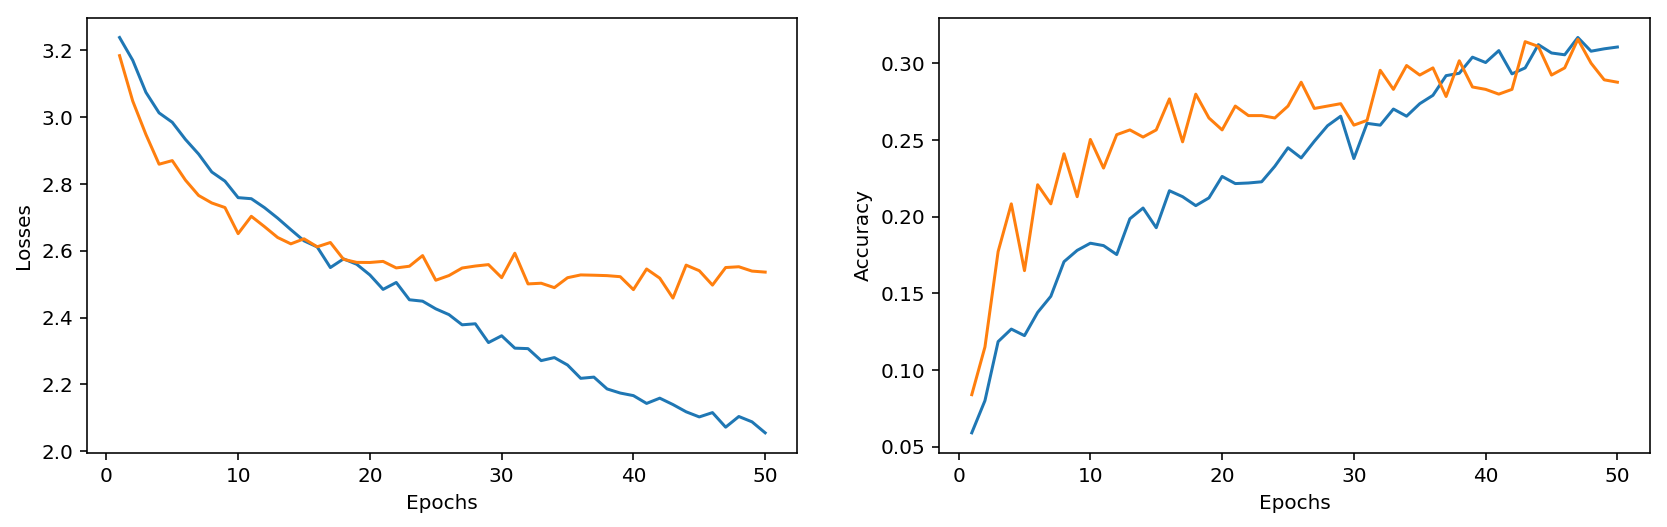

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax[0].plot(range(1, NB_EPOCHS + 1), history['loss'])
ax[0].plot(range(1, NB_EPOCHS + 1), history['val_loss'])
_ = ax[0].set(xlabel='Epochs', ylabel='Losses')
ax[1].plot(range(1, NB_EPOCHS + 1), history['acc'])
ax[1].plot(range(1, NB_EPOCHS + 1), history['val_acc'])
_ = ax[1].set(xlabel='Epochs', ylabel='Accuracy')

## 3. Visualizing Predictions

In [48]:
from keras.models import load_model
learning_from_scratch_model = load_model('models/learning_from_scratch.h5')

**Class Name to Class Index Mapping:**

In [49]:
class_to_index = train_generator.class_indices
class_to_index

{'beans': 0,
 'cake': 1,
 'candy': 2,
 'cereal': 3,
 'chips': 4,
 'chocolate': 5,
 'coffee': 6,
 'corn': 7,
 'fish': 8,
 'flour': 9,
 'honey': 10,
 'jam': 11,
 'juice': 12,
 'milk': 13,
 'nuts': 14,
 'oil': 15,
 'pasta': 16,
 'rice': 17,
 'soda': 18,
 'spices': 19,
 'sugar': 20,
 'tea': 21,
 'tomatosauce': 22,
 'vinegar': 23,
 'water': 24}

**Class Index to Class Name Mapping:**

In [50]:
index_to_class = {v: k for k, v in train_generator.class_indices.items()}
index_to_class

{0: 'beans',
 1: 'cake',
 2: 'candy',
 3: 'cereal',
 4: 'chips',
 5: 'chocolate',
 6: 'coffee',
 7: 'corn',
 8: 'fish',
 9: 'flour',
 10: 'honey',
 11: 'jam',
 12: 'juice',
 13: 'milk',
 14: 'nuts',
 15: 'oil',
 16: 'pasta',
 17: 'rice',
 18: 'soda',
 19: 'spices',
 20: 'sugar',
 21: 'tea',
 22: 'tomatosauce',
 23: 'vinegar',
 24: 'water'}

In [51]:
## set path for images
TRAIN_IMG_PATH = 'data/train_img/'
TEST_IMG_PATH = 'data/test_img/'

In [52]:
from keras.preprocessing import image
from keras.models import load_model

from PIL import Image

def predict(model, img, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    """Run model prediction on image
    Args:
    model: keras model
    img: PIL format image
    target_size: (w,h) tuple
    Returns:
    list of predicted labels and their probabilities
    """
    if img.size != target_size:
        img = img.resize(target_size)

    x = image.img_to_array(img)
    x = x / 255
    x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)
    #preds = model.predict(x)
    preds = model.predict_classes(x)
    # Although one image but preds is returned as an array of one element, so we need preds[0]
    #return np.argmax(preds[0])
    return preds[0]

In [53]:
import pandas as pd
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

### 3.1 Visualizing Predictions on Random Training Samples

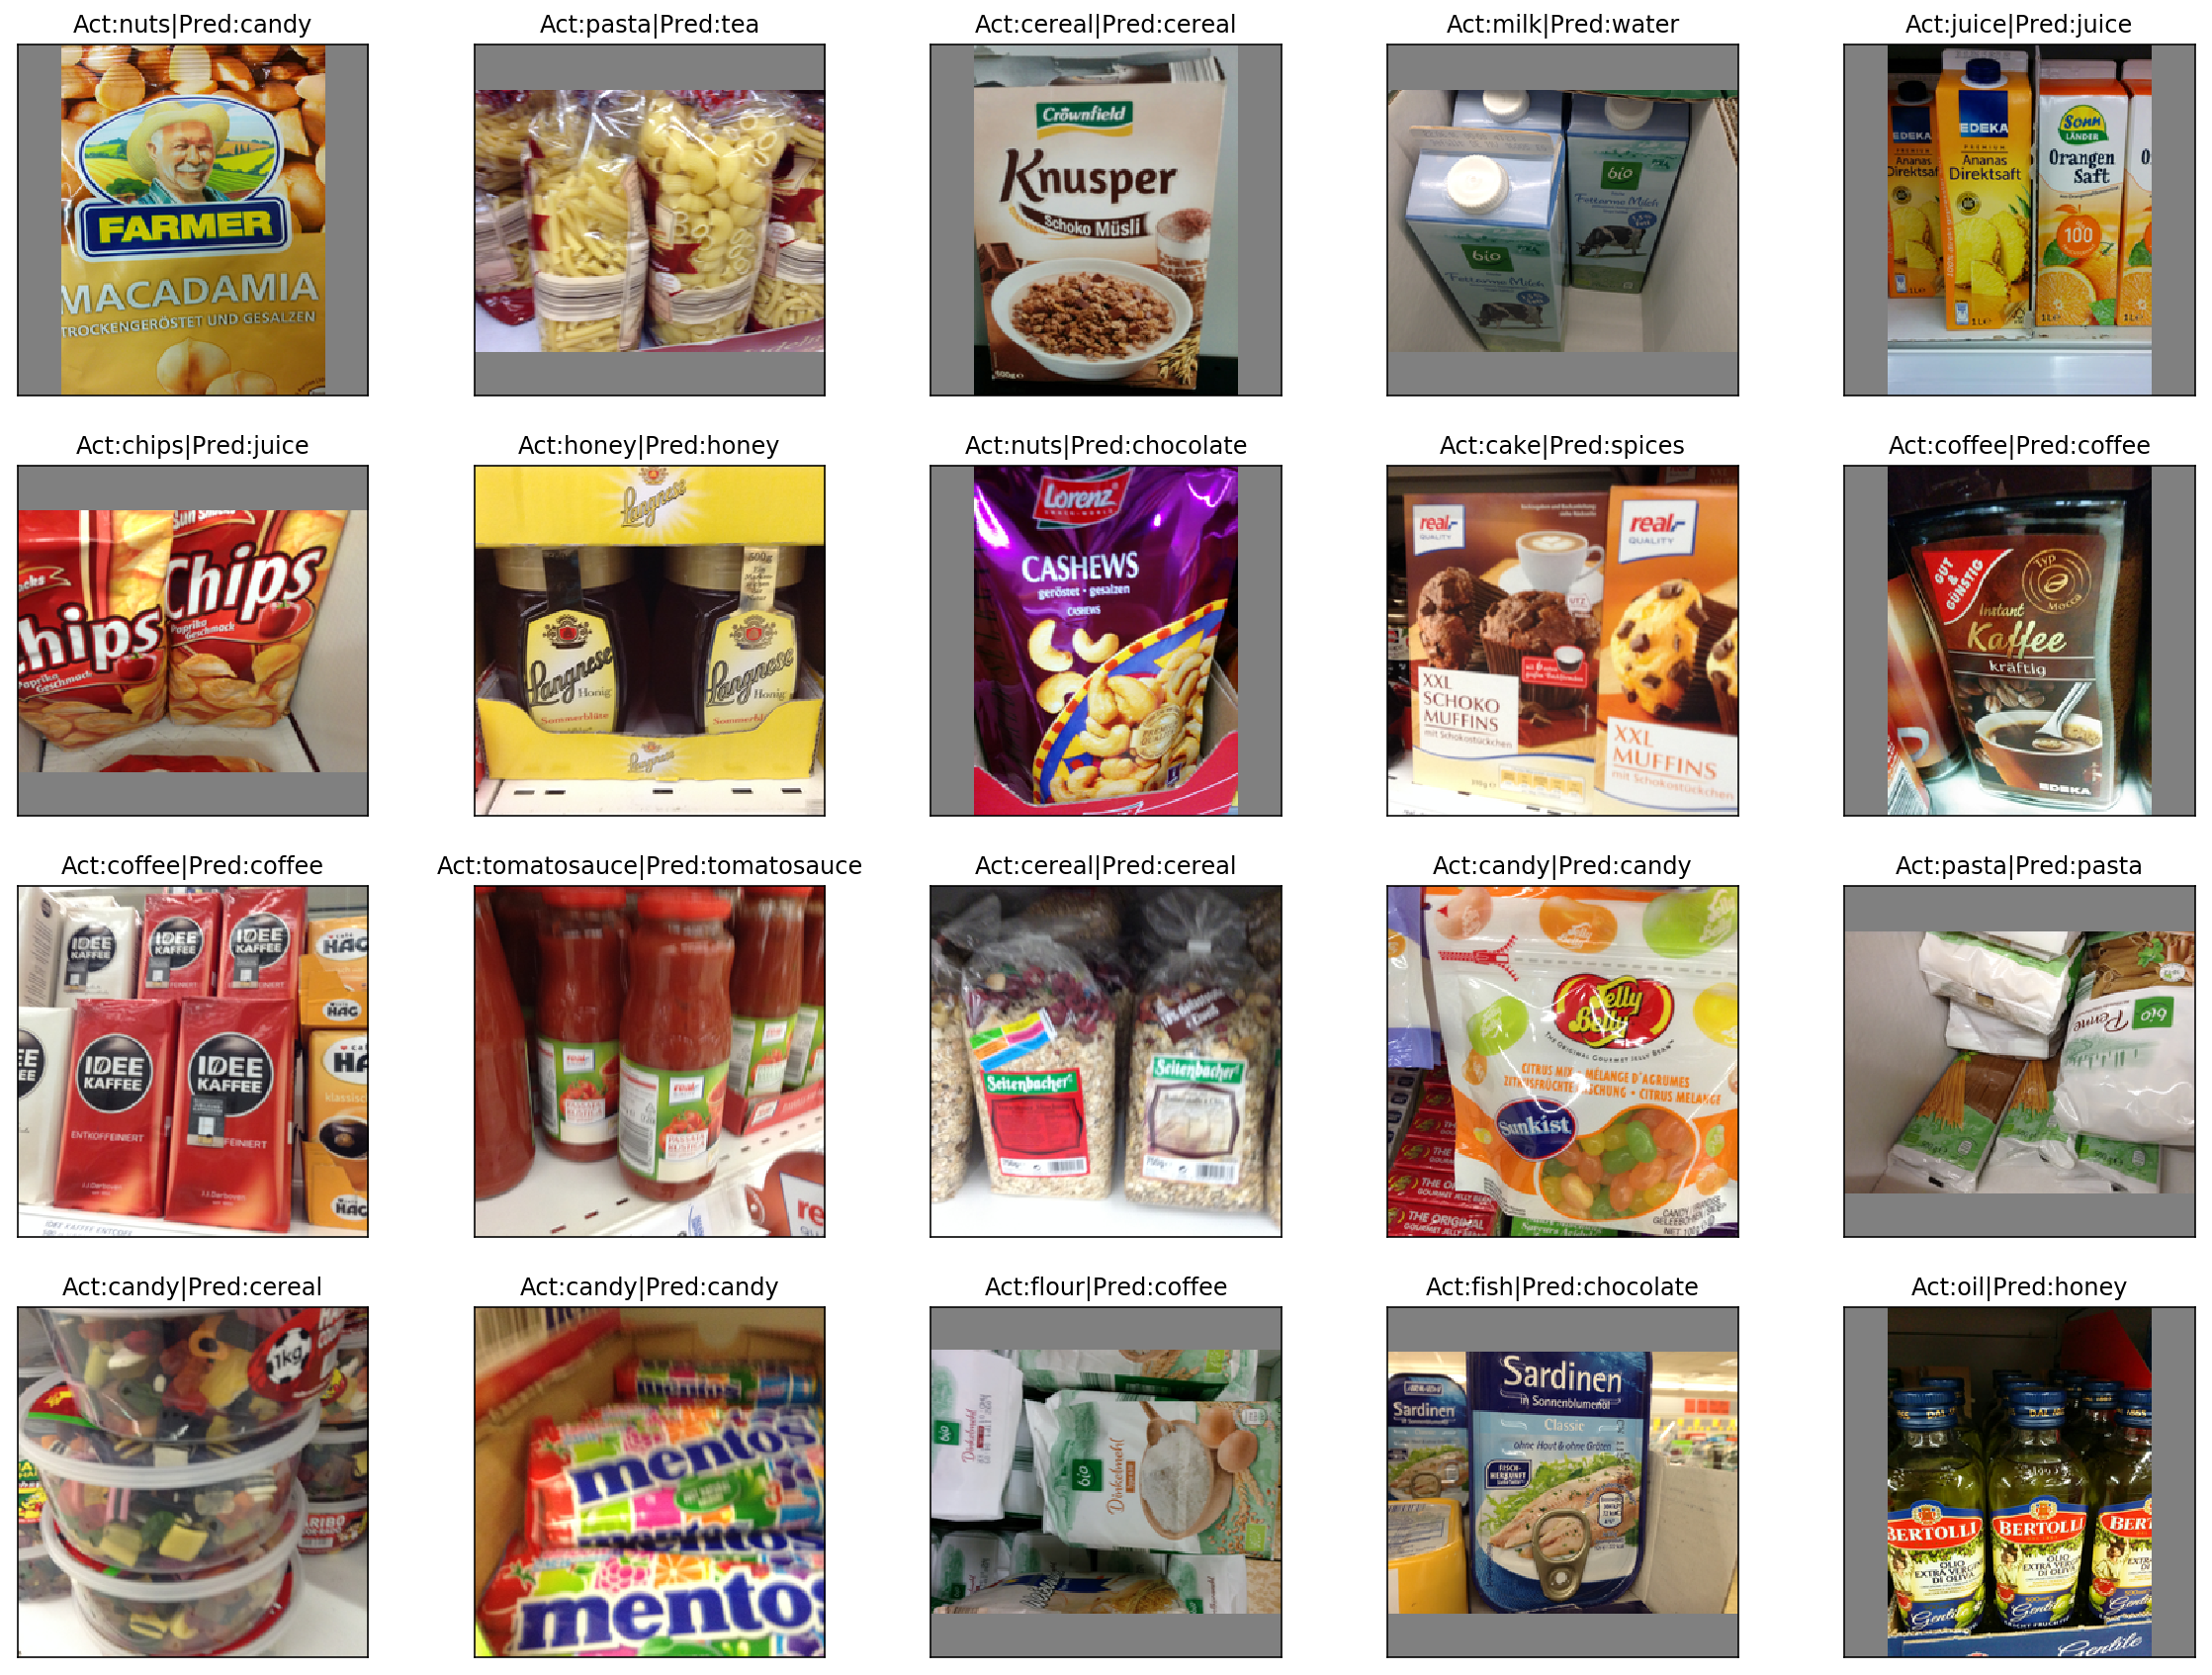

In [54]:
import cv2
fig = plt.figure(figsize=(20, 15))
nrows, ncols = 4, 5
for i, row in enumerate(train_df.sample(nrows * ncols, random_state=seed).itertuples(index=False)):
    ax = fig.add_subplot(nrows, ncols, i + 1, xticks=[], yticks=[])
    img_path, img_label = TRAIN_IMG_PATH + row[0] + '.png', row[1]
    pred = predict(learning_from_scratch_model, Image.open(img_path))
    img = cv2.imread(img_path)
    ax.imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (256, 256)))
    ax.set_title('Act:{0}|Pred:{1}'.format(img_label, index_to_class[pred]))    

### 3.2 Visualizing Predictions on Random Testing Samples

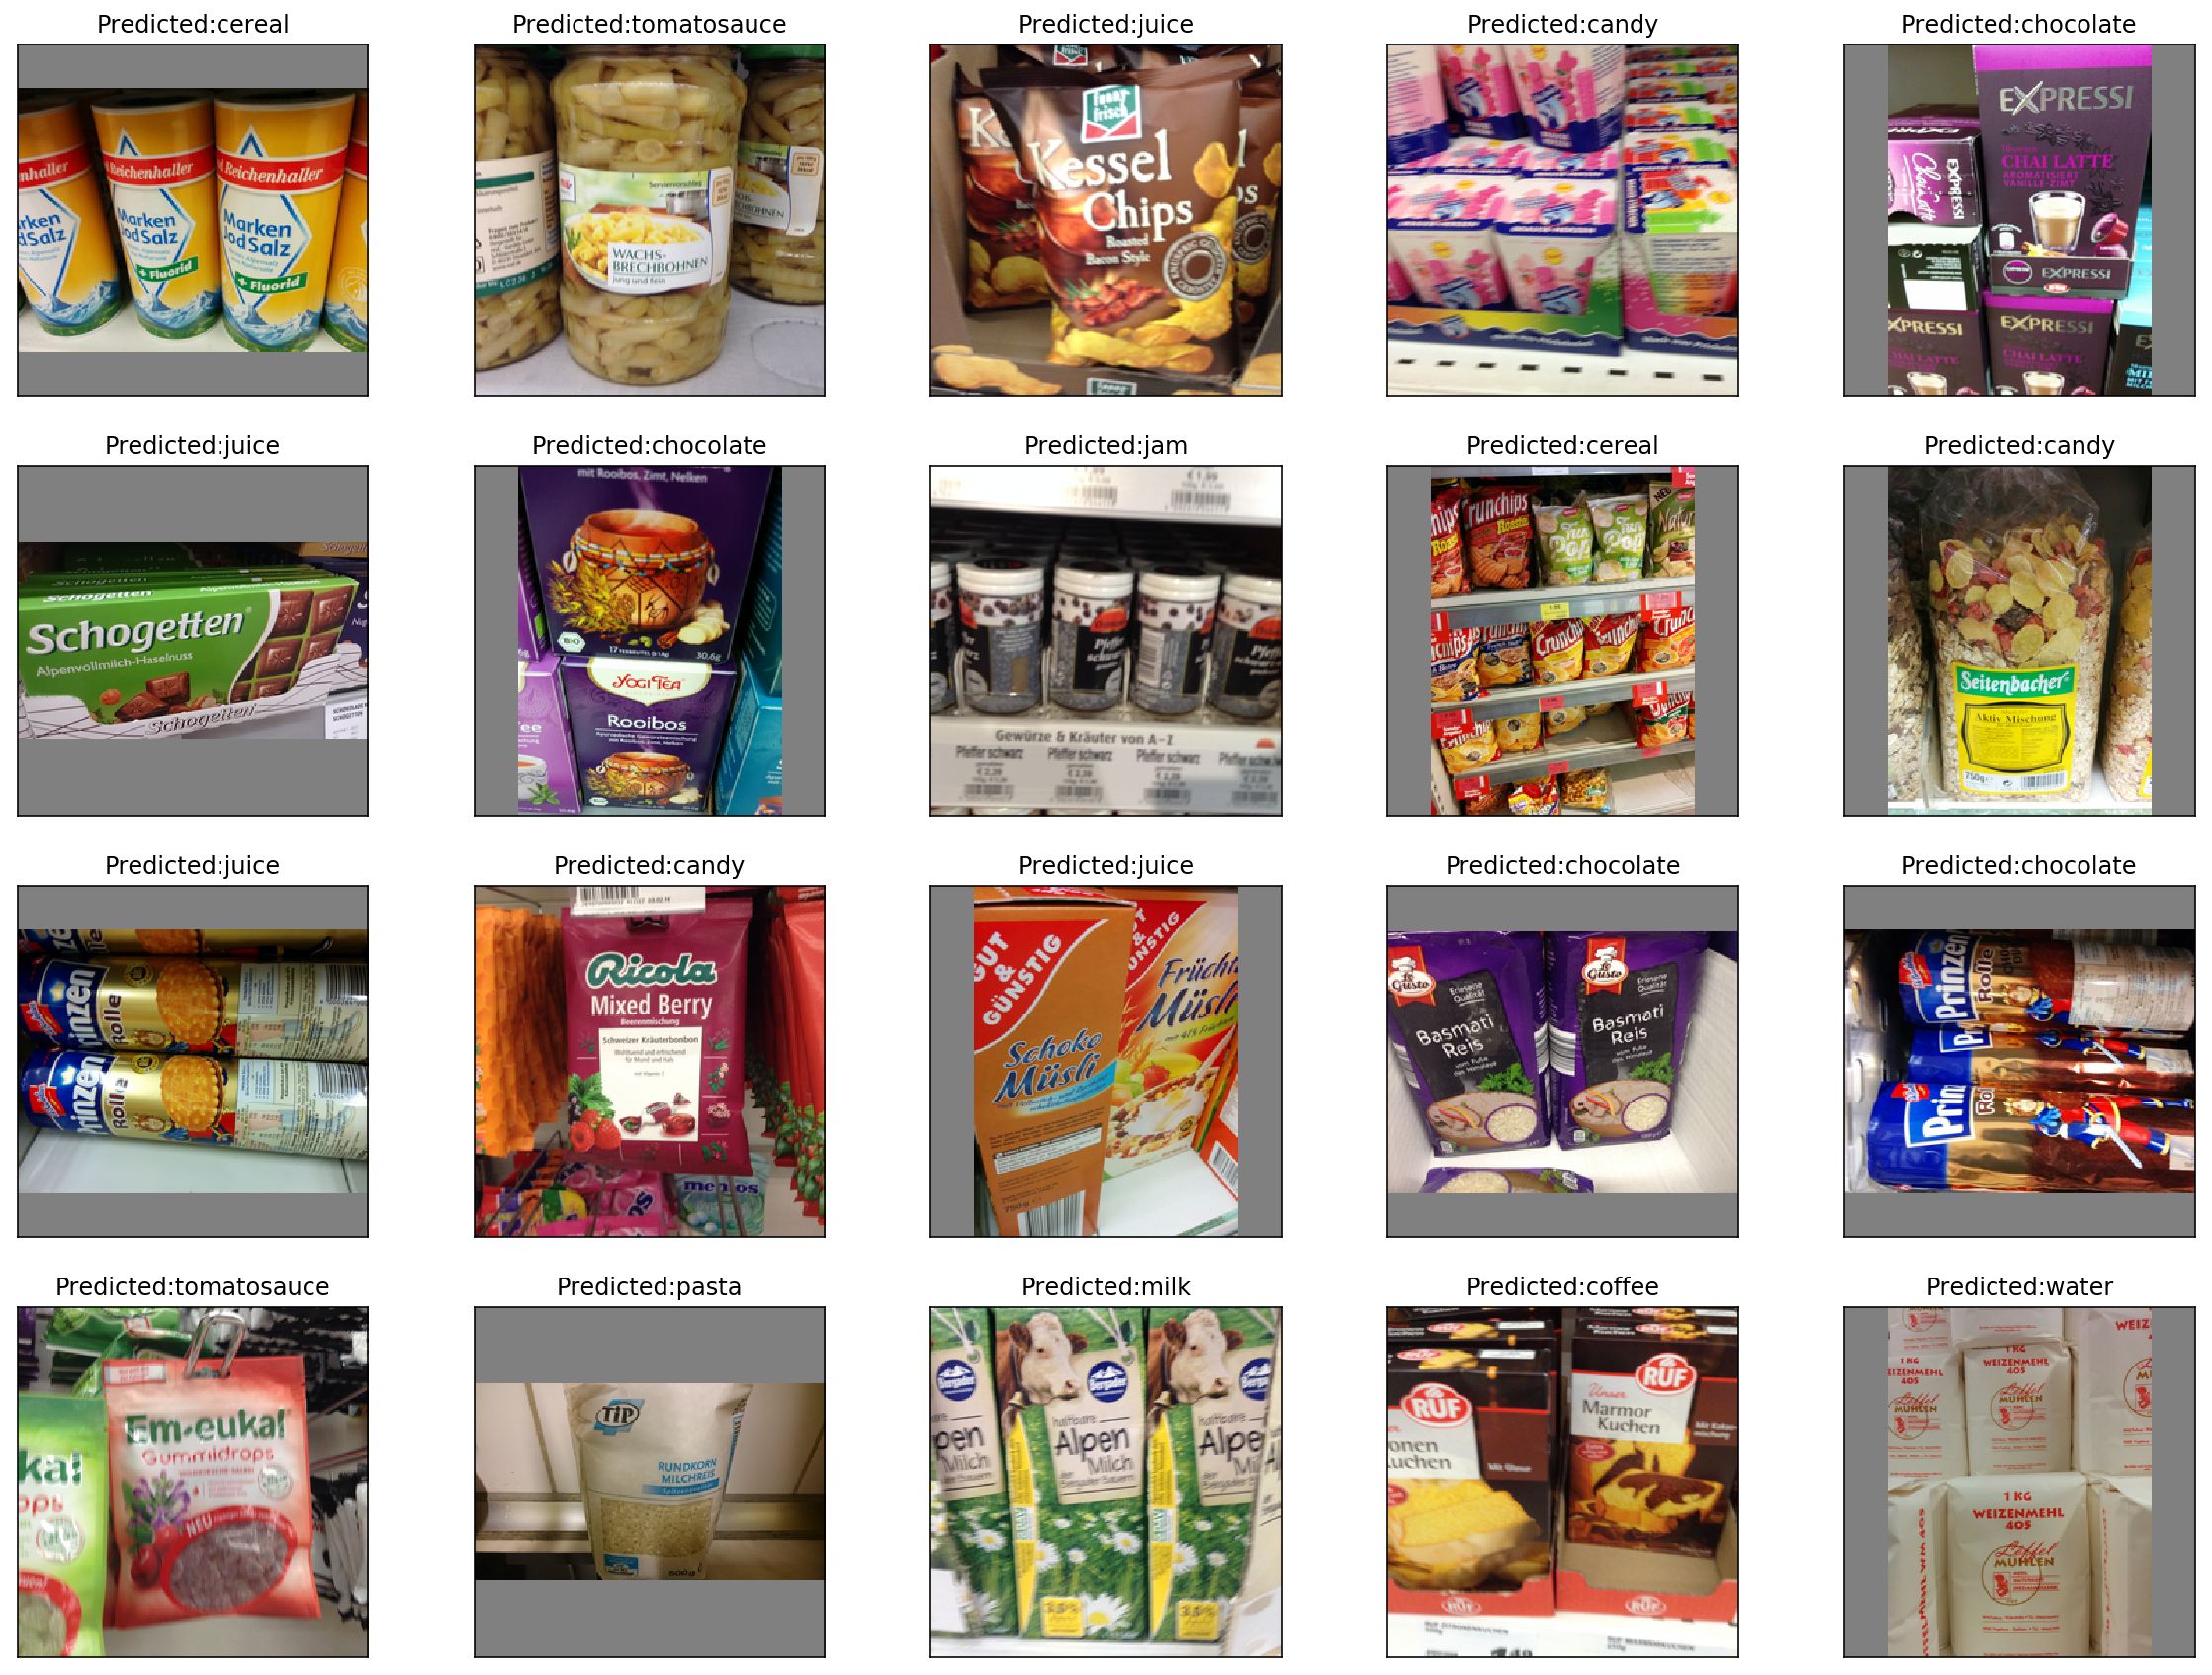

In [55]:
import cv2
fig = plt.figure(figsize=(20, 15))
nrows, ncols = 4, 5
for i, row in enumerate(test_df.sample(nrows * ncols, random_state=seed).itertuples(index=False)):
    ax = fig.add_subplot(nrows, ncols, i + 1, xticks=[], yticks=[])
    img_path = TEST_IMG_PATH + row[0] + '.png'
    pred = predict(model, Image.open(img_path))
    img = cv2.imread(img_path)
    ax.imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (256, 256)))
    ax.set_title('Predicted:{0}'.format(index_to_class[pred]))

## 4. Generate Submissions on Test Data

In [56]:
# function to read images as arrays
def read_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) # you can resize to (128,128) or (256,256)
    return img

In [57]:
from tqdm import tqdm
test_data = []
    
for img in tqdm(test_df['image_id'].values):
    test_data.append(read_image(TEST_IMG_PATH + '{}.png'.format(img)))

100%|██████████| 1732/1732 [00:07<00:00, 236.26it/s]


In [58]:
# normalize the images
X_test = np.array(test_data, np.float32) / 255.

In [59]:
preds = learning_from_scratch_model.predict(X_test)
preds = np.argmax(preds, axis= 1)

In [60]:
pred_labels = [index_to_class[pred] for pred in preds]

In [61]:
# make submission
learn_from_scratch_df = pd.DataFrame({'image_id':test_df['image_id'], 'label':pred_labels})
learn_from_scratch_df.to_csv('submissions/learn_from_scratch.csv', index=False)